In [1]:
import matplotlib
import importlib
import ventos.signal as signal
import ventos.sim.simple as simple
import pandas as pd, matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [10,7]

pd.set_option('precision', 4)



In [2]:
def plots(pdf, title):
    fig, plots = plt.subplots(3, sharex=True) # , gridspec_kw={'hspace': 0}
    (ax1, ax2, ax3) = plots
    for ax in plots:
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plots[-1].spines['bottom'].set_visible(True)
        
    fig.suptitle(title)
    ax1.plot(pdf['time'] / 1000, pdf['flow'], 'dimgray')
    ax1.plot(pdf['time'] / 1000, pdf['flow_i'], 'tab:orange')
    ax1.plot(pdf['time'] / 1000, pdf['flow_e'], 'tab:blue')

    ax1.set(ylabel = 'Flow (l/s)')
    ax2.plot(pdf['time'] / 1000, pdf['pressure_mouth'], 'dimgray')
    ax2.plot(pdf['time'] / 1000, pdf['pressure_1'], 'tab:green')
    ax2.plot(pdf['time'] / 1000, pdf['pressure_2'], 'tab:green')

    ax2.set(ylabel = 'P (cmH2O)')
    ax3.plot(pdf['time'] / 1000, pdf['lung_volume'], 'tab:orange')
    ax3.set(ylabel = 'Volume (ml)', xlabel = 'time (seconds)')
    ax1.label_outer()
    ax2.label_outer()
    plt.show()
    


In [14]:
def run_and_output(scenario):
    print(scenario)
    pdf = simple.execute_scenario(scenario)
    plots(pdf, title=s['title'])
    return pdf


In [15]:
base_scenario = dict(
    title = 'Base',
    resistance = 20,
    PEEP = 5,
    IE = 0.5,
    Pi = 15,
    rate = 10,
    end_time = 30,
    time_resolution = 50,
    flow_noise_sd = 0.05,
    pressure_noise_sd = 1,
    heart_rate = 85,
    cardiac_amplitude = 0.05,
    events = []
)
e= 30
r= 500
c= 0.1
badness = [
    dict(attr = 'PEEP', val = 10, time=4),
    dict(attr = 'Pi', val = 15, time=6),
    dict(attr = 'Pi', val = 13, time=10),

]

{'title': 'Badness', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 15, 'rate': 10, 'end_time': 30, 'time_resolution': 500, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 60, 'cardiac_amplitude': 0.1, 'events': [{'attr': 'PEEP', 'val': 10, 'time': 4}, {'attr': 'Pi', 'val': 15, 'time': 6}, {'attr': 'Pi', 'val': 13, 'time': 10}]}
Event at 4000ms setting PEEP to 10
Event at 6000ms setting Pi to 15
Event at 10000ms setting Pi to 13


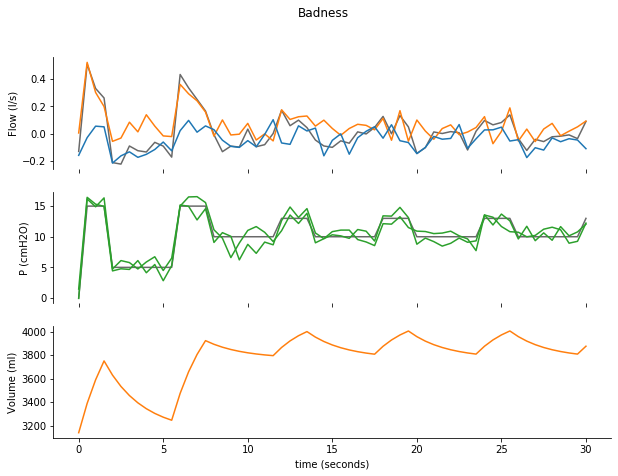

In [16]:
scenarios = [
    dict(base_scenario, title='Badness', 
         cardiac_amplitude = c, end_time = e, heart_rate = 60, time_resolution = r,
         events=badness),
]
held_senarios = [
    base_scenario,
    dict(base_scenario, title='Cardiac 30', cardiac_amplitude = c, end_time = e, heart_rate = 30, time_resolution = r),
    dict(base_scenario, title='Cardiac 120', cardiac_amplitude = c, end_time = e, heart_rate = 120, time_resolution = r),
    dict(base_scenario, title='High Resistance', resistance = 80),
    dict(base_scenario, title='Low Pressure', Pi = 7),
    dict(base_scenario, title='Wimpy', PEEP = 7, Pi=10),
    dict(base_scenario, title='High Pressure', PEEP = 14),
    dict(base_scenario, title='Stuck High', PEEP = 14, Pi = 14),
    dict(base_scenario, title='Crazy fast', rate = 60),   
    dict(base_scenario, title='Too slow', rate = 3),   
    dict(base_scenario, title='No expiration time', rate = 12, IE = 5),   
]
for s in scenarios:
    run_and_output(s)

{'title': 'Base', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 15, 'rate': 10, 'end_time': 30, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05, 'events': []}


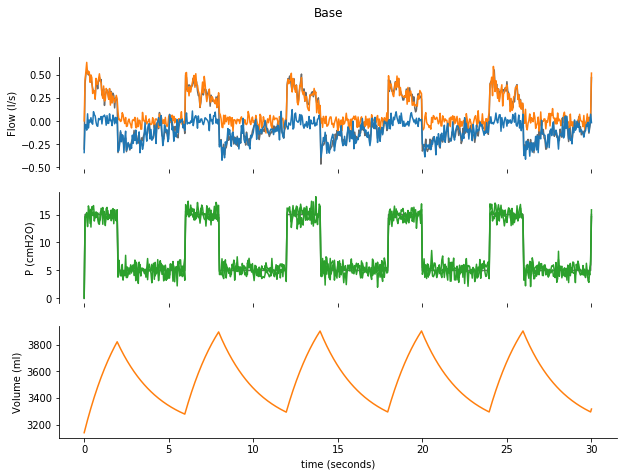

[{"event":"M","type":"P","loc":"I","ms":0,"val":0},{"event":"M","type":"P","loc":"E","ms":0,"val":0},{"event":"M","type":"F","loc":"I","ms":0,"val":217},{"event":"M","type":"F","loc":"E","ms":0,"val":-20359},{"event":"M","type":"P","loc":"I","ms":50,"val":14},{"event":"M","type":"P","loc":"E","ms":50,"val":15},{"event":"M","type":"F","loc":"I","ms":50,"val":26611},{"event":"M","type":"F","loc":"E","ms":50,"val":-2134},{"event":"M","type":"P","loc":"I","ms":100,"val":15},{"event":"M","type":"P","loc":"E","ms":100,"val":15},{"event":"M","type":"F","loc":"I","ms":100,"val":32839},{"event":"M","type":"F","loc":"E","ms":100,"val":-2590},{"event":"M","type":"P","loc":"I","ms":150,"val":15},{"event":"M","type":"P","loc":"E","ms":150,"val":15},{"event":"M","type":"F","loc":"I","ms":150,"val":38260},{"event":"M","type":"F","loc":"E","ms":150,"val":-5783},{"event":"M","type":"P","loc":"I","ms":200,"val":13},{"event":"M","type":"P","loc":"E","ms":200,"val":13},{"event":"M","type":"F","loc":"I","m

In [7]:
pdf = run_and_output(base_scenario)        
print(simple.df_to_PIRDS(pdf.head()).to_json(orient="records"))

{'title': 'Base', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 15, 'rate': 10, 'end_time': 30, 'time_resolution': 50, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05, 'events': []}


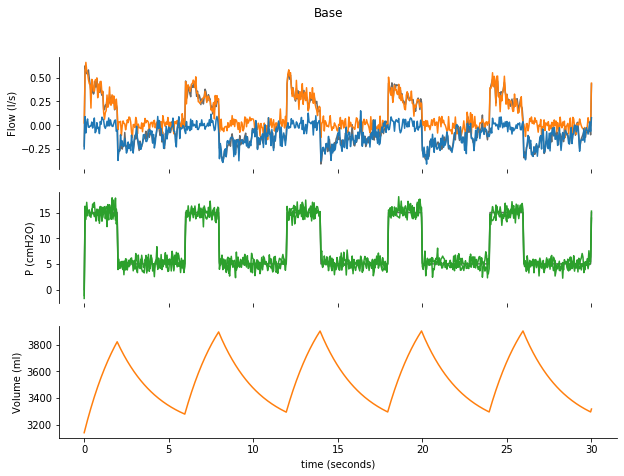

In [8]:
pdf = run_and_output(base_scenario)

In [9]:
f = pdf.head(5).to_json(orient='records')

In [10]:
vs = signal.VentilatorStatus()
config = signal.VentilatorConfig()

{'title': 'Base', 'resistance': 20, 'PEEP': 5, 'IE': 0.5, 'Pi': 20, 'rate': 10, 'end_time': 240, 'time_resolution': 100, 'flow_noise_sd': 0.05, 'pressure_noise_sd': 1, 'heart_rate': 85, 'cardiac_amplitude': 0.05, 'events': [{'attr': 'PEEP', 'val': 10, 'time': 40}, {'attr': 'Pi', 'val': 15, 'time': 46}, {'attr': 'Pi', 'val': 13, 'time': 50}, {'attr': 'PEEP', 'val': 13, 'time': 55}, {'attr': 'PEEP', 'val': 5, 'time': 120}, {'attr': 'Pi', 'val': 20, 'time': 121}]}
Event at 40000ms setting PEEP to 10
Event at 46000ms setting Pi to 15
Event at 50000ms setting Pi to 13
Event at 55000ms setting PEEP to 13
Event at 120000ms setting PEEP to 5
Event at 121000ms setting Pi to 20


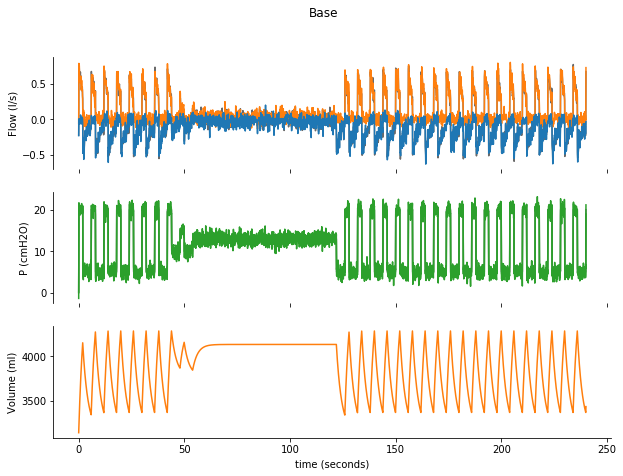

In [11]:
sample_frequency = 10
start = 40
fix = 120
badness = [
    dict(attr = 'PEEP', val = 10, time=start),
    dict(attr = 'Pi', val = 15, time=start+6),
    dict(attr = 'Pi', val = 13, time=start+10),
    dict(attr = 'PEEP', val = 13, time=start+15),
    dict(attr = 'PEEP', val = 5, time=fix),
    dict(attr = 'Pi', val = 20, time=fix+1),
]
scenario = dict(base_scenario,
                Pi=20, PEEP=5,
                time_resolution = round(1000/sample_frequency), end_time = 240,
                events = badness)
sim = run_and_output(scenario)

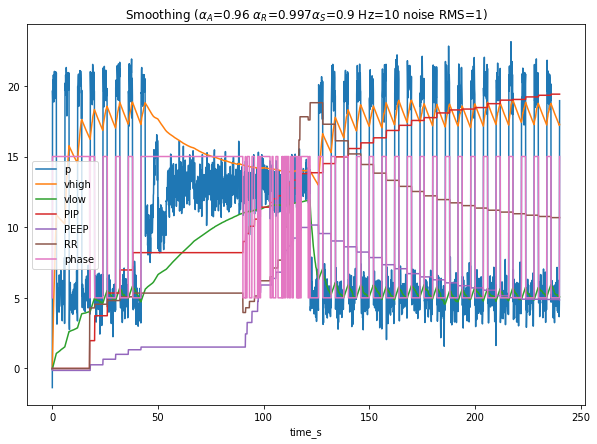

In [17]:
importlib.reload(signal)
config.sample_frequency = sample_frequency 

config.alphaA = 0.96
config.alphaR = 0.997
results = signal.process_trace(sim, config, pressure_column='pressure_1')
results.plot(x='time_s', y=['p', 
                            'vhigh', 'vlow', 
                            # 'Vhigh', 'Vlow', # 'Thigh', 'Tlow', 'Tpeak',
                          'PIP', 'PEEP', 'RR', 'phase'],
            title = "Smoothing "
             rf"($\alpha_A$={config.alphaA} $\alpha_R$={config.alphaR}$\alpha_S$={config.alphaS}"
             f" Hz={config.sample_frequency} noise RMS={scenario['pressure_noise_sd']})"
                      )
plt.show()

In [13]:
scenario

{'title': 'Base',
 'resistance': 20,
 'PEEP': 5,
 'IE': 0.5,
 'Pi': 20,
 'rate': 10,
 'end_time': 240,
 'time_resolution': 100,
 'flow_noise_sd': 0.05,
 'pressure_noise_sd': 1,
 'heart_rate': 85,
 'cardiac_amplitude': 0.05,
 'events': []}